# Unsupervised surgery pipeline with TRVAE

In [1]:
import os
os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown

INFO:lightning_fabric.utilities.seed:Global seed set to 0
/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 captum (see https://github.com/pytorch/captum).


In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

### Set relevant anndata.obs labels and training length

Here we use the CelSeq2 and SS2 studies as query data and the other 3 studies as reference atlas. We strongly suggest to use earlystopping to avoid over-fitting. The best earlystopping criteria is the 'val_unweighted_loss' for TRVAE.

In [4]:
condition_key = 'study'
cell_type_key = 'cell_type'
target_conditions = ['Pancreas CelSeq2', 'Pancreas SS2']


trvae_epochs = 500
surgery_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

### Download Dataset and split into reference dataset and query dataset

In [5]:
url = 'https://drive.google.com/uc?id=1ehxgfHTsMZXy6YzlFKGJOsBKQ5rrvMnd'
output = 'pancreas.h5ad'
gdown.download(url, output, quiet=False)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1ehxgfHTsMZXy6YzlFKGJOsBKQ5rrvMnd
From (redirected): https://drive.google.com/uc?id=1ehxgfHTsMZXy6YzlFKGJOsBKQ5rrvMnd&confirm=t&uuid=ba33dab1-820f-4152-ada0-90fb7c85a2a9
To: /Users/ergonyc/Projects/SingleCell/scarches/pancreas.h5ad
100%|██████████| 126M/126M [00:05<00:00, 23.6MB/s] 


'pancreas.h5ad'

In [5]:
adata_all = sc.read('pancreas.h5ad')

This line makes sure that count data is in the adata.X. Remember that count data in adata.X is necessary when using "nb" or "zinb" loss. However, when using trVAE with MSE loss normalized data is necessary in adata.X

In [6]:
adata = adata_all.raw.to_adata()
adata = remove_sparsity(adata)
source_adata = adata[~adata.obs[condition_key].isin(target_conditions)]
target_adata = adata[adata.obs[condition_key].isin(target_conditions)]
source_conditions = source_adata.obs[condition_key].unique().tolist()

In [8]:
source_adata.X[:10, :10]

ArrayView([[  0., 118.,   0.,   0., 211.,   0.,   0.,   0., 509., 114.],
           [  0., 112.,   0.,   0.,  47.,   0.,   0.,   0., 415.,  67.],
           [  0.,  44.,   0.,   0.,  10.,   0.,   0.,   0., 454., 188.],
           [  0.,  35.,   0.,   0.,  14.,   0.,   0.,   0., 487.,  32.],
           [  0.,  55.,   0.,   0.,  48.,   0.,   0.,   0., 194.,   0.],
           [  0.,  43.,   0.,   0.,   8.,   0.,   0.,   0., 360.,  40.],
           [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
           [  0.,  94.,   1.,   0.,  86.,   0.,   0.,   0., 436.,   8.],
           [  0.,  53.,   0.,   0.,  90.,   1.,   0.,   0., 203.,   0.],
           [  0.,  71.,   0.,   0.,  96.,   0.,   0.,   0., 512.,   4.]],
          dtype=float32)

In [9]:
target_adata

View of AnnData object with n_obs × n_vars = 5387 × 1000
    obs: 'batch', 'study', 'cell_type', 'size_factors'

### Create TRVAE model and train it on reference dataset

Create the trVAE model instance with NB loss as default. Insert "recon_loss='mse'," or "recon_loss='zinb'," to change the reconstruction loss.

In [10]:
trvae = sca.models.TRVAE(
    adata=source_adata,
    condition_key=condition_key,
    conditions=source_conditions,
    hidden_layer_sizes=[128, 128],
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1000 128 3
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 3
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 1000 



In [11]:
trvae.train(
    n_epochs=trvae_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs
)

Preparing (10294, 1000)
Instantiating dataset
 |████----------------| 24.0%  - val_loss: 566.8380262587 - val_recon_loss: 551.8037990994 - val_kl_loss: 15.5235807631 - val_mmd_loss: 5.79770702798
ADJUSTED LR
 |█████---------------| 25.4%  - val_loss: 580.5192735460 - val_recon_loss: 565.2907206217 - val_kl_loss: 15.2185259925 - val_mmd_loss: 5.6408827040
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 105


### Create anndata file of latent representation and compute UMAP

In [12]:
adata_latent = sc.AnnData(trvae.get_latent())
adata_latent.obs['cell_type'] = source_adata.obs[cell_type_key].tolist()
adata_latent.obs['batch'] = source_adata.obs[condition_key].tolist()

/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/si

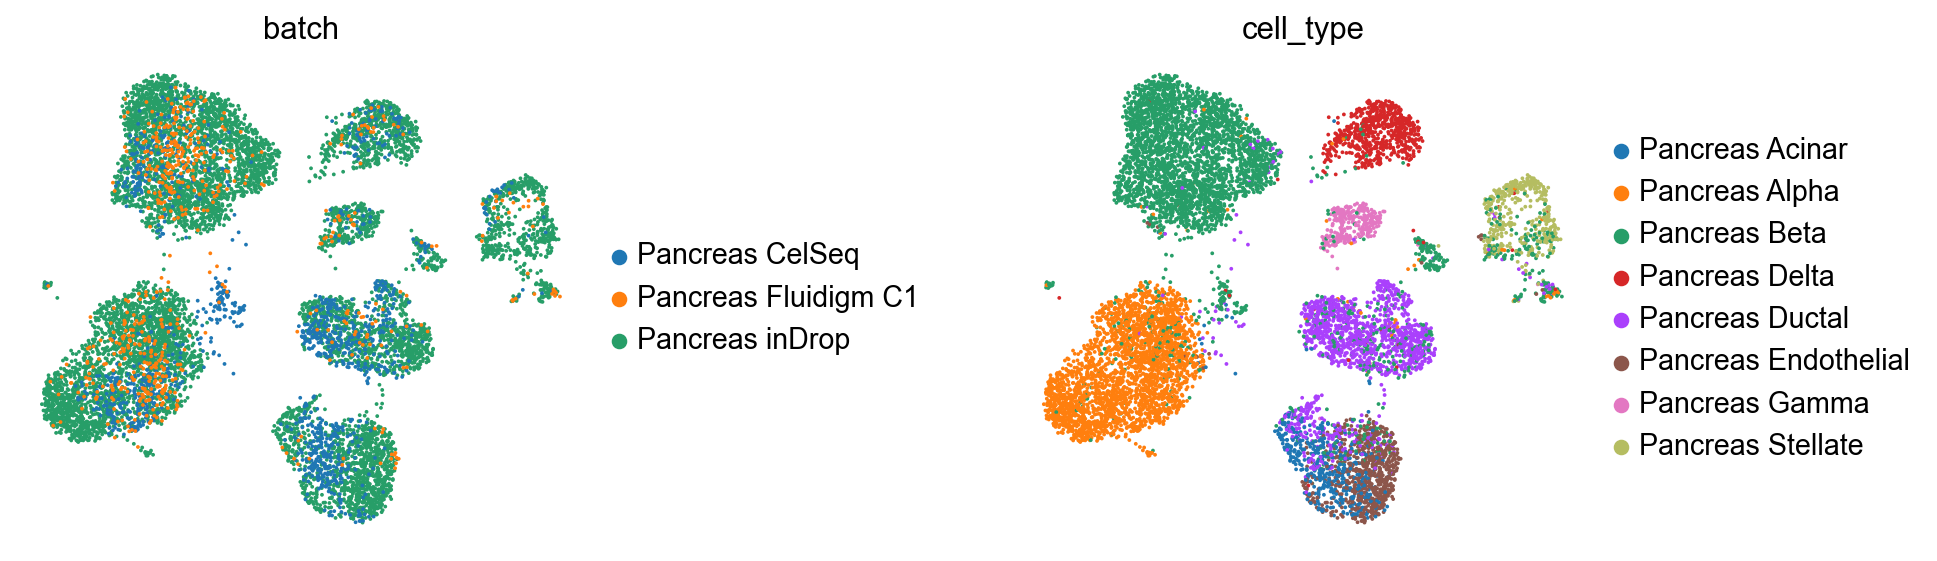

In [13]:
sc.pp.neighbors(adata_latent, n_neighbors=8)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

After pretraining the model can be saved for later use

In [14]:
ref_path = 'reference_model/'
trvae.save(ref_path, overwrite=True)

### Perform surgery on reference model and train on query dataset

In [15]:
new_trvae = sca.models.TRVAE.load_query_data(adata=target_adata, reference_model=ref_path)

View of AnnData object with n_obs × n_vars = 5387 × 1000
    obs: 'batch', 'study', 'cell_type', 'size_factors'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1000 128 5
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 5
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 1000 



In [16]:
new_trvae.train(
    n_epochs=surgery_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs,
    weight_decay=0
)

Preparing (5387, 1000)
Instantiating dataset
 |███-----------------| 16.6%  - val_loss: 1258.6113769531 - val_recon_loss: 1249.7563720703 - val_kl_loss: 19.1188880920 - val_mmd_loss: 1.0162761688
ADJUSTED LR
 |███-----------------| 18.0%  - val_loss: 1280.9147705078 - val_recon_loss: 1271.2949462891 - val_kl_loss: 19.1845176697 - val_mmd_loss: 1.0827247620
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 68


In [17]:
adata_latent = sc.AnnData(new_trvae.get_latent())
adata_latent.obs['cell_type'] = target_adata.obs[cell_type_key].tolist()
adata_latent.obs['batch'] = target_adata.obs[condition_key].tolist()

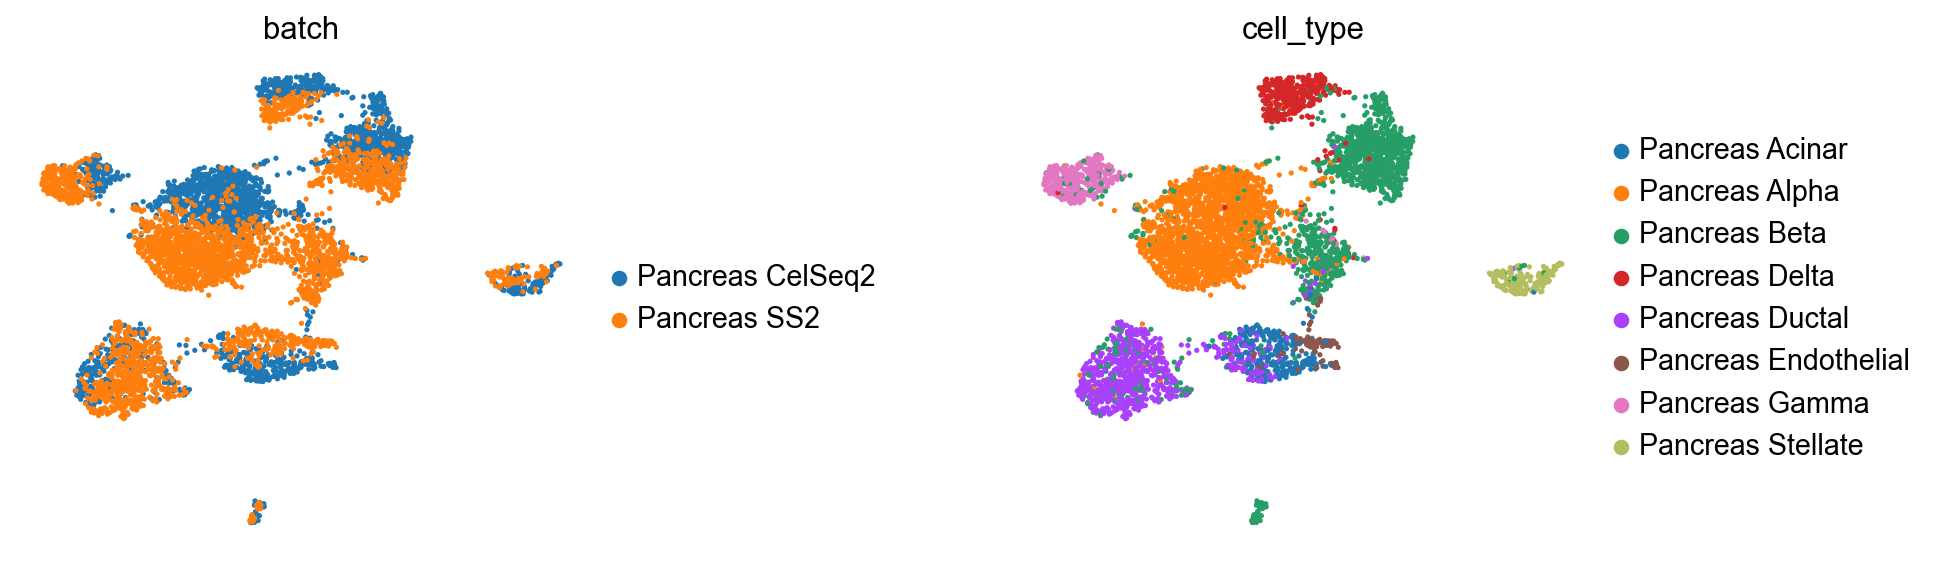

In [18]:
sc.pp.neighbors(adata_latent, n_neighbors=8)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [19]:
surg_path = 'surgery_model'
new_trvae.save(surg_path, overwrite=True)

### Get latent representation of reference + query dataset and compute UMAP

In [20]:
full_latent = sc.AnnData(new_trvae.get_latent(adata.X, adata.obs[condition_key]))
full_latent.obs['cell_type'] = adata.obs[cell_type_key].tolist()
full_latent.obs['batch'] = adata.obs[condition_key].tolist()

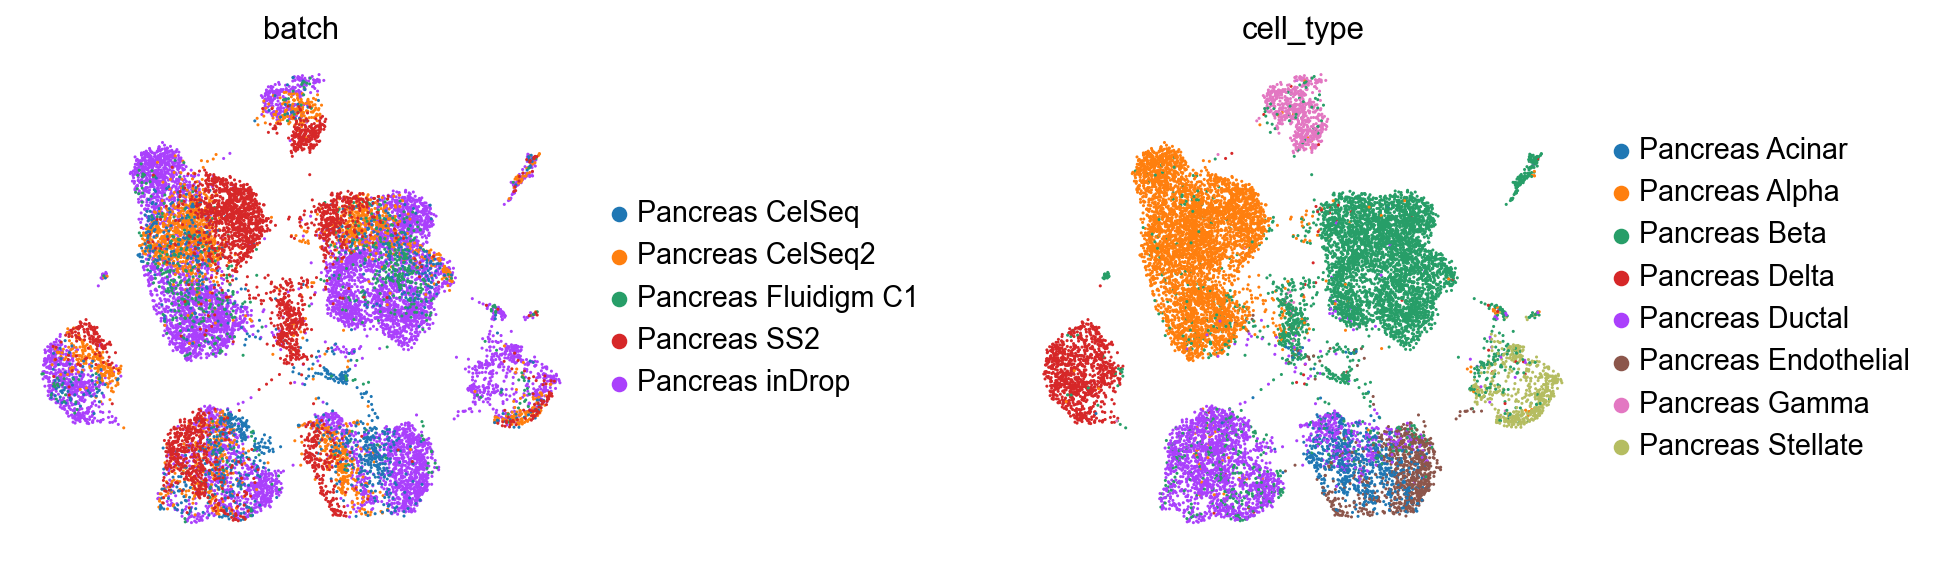

In [21]:
sc.pp.neighbors(full_latent, n_neighbors=8)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)
sc.pl.umap(full_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )